In [30]:
import numpy as np 
import open3d as o3d
import cv2

In [31]:
def to_3D(fx, fy, depth, cx, cy):
    H, W = depth.shape

    u, v = np.meshgrid(np.arange(W), np.arange(H))

    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth

    return np.stack((x, y, z), axis=-1)   # HxWx3


def make_o3d_pointcloud(rgb_path, depth_path, fx, fy, cx, cy):
    
    if type(rgb_path) != str:
        rgb = rgb_path
    else:
        rgb = cv2.imread(rgb_path)[:, :, ::-1]
    
    if type(depth_path) != str:
        depth = depth_path
    else:
        depth = np.load(depth_path).astype(np.float32) / 1000 ## convert mm depth map to meter

    # ----- CREATE MASK -----
    mask = (depth > 0) & np.isfinite(depth)   # boolean mask HxW

    # Unproject entire depth → xyz
    xyz = to_3D(fx, fy, depth, cx, cy)   # HxW x 3

    # Flatten arrays
    xyz_flat = xyz.reshape(-1, 3)
    rgb_flat = rgb.reshape(-1, 3)
    mask_flat = mask.reshape(-1)

    # Apply mask
    xyz_valid = xyz_flat[mask_flat]
    rgb_valid = rgb_flat[mask_flat] / 255.0

    # Build point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz_valid)
    pcd.colors = o3d.utility.Vector3dVector(rgb_valid)

    return pcd


In [14]:
project_folder = "data/final_project_dataset/"
rgb = f"{project_folder}kinect-rgb-images/kinect_frame-001802.rgb.jpg"
depth = f"{project_folder}/kinect-depth-images/kinect_frame-001802.depth.npy"
pose = f"{project_folder}/crazyflie-poses/crazyflie_frame-001802.pose.txt"
fx = 218.792814876677
fy = 224.37416225752526
cx = 322.66660990415625
cy = 243.22672826370496

pcd = make_o3d_pointcloud(rgb, depth, fx, fy, cx, cy)

T_cam_to_world = np.loadtxt(pose).reshape(4,4)

# --- apply transform ---
pcd.transform(T_cam_to_world)

PointCloud with 307200 points.

In [15]:
o3d.visualization.draw_geometries([pcd])


In [16]:

fx = 218.792814876677
fy = 224.37416225752526
cx = 322.66660990415625
cy = 243.22672826370496

In [25]:
# Create pointcloud for each image 
import glob
import os
import numpy as np
import open3d as o3d

project = "data/demo_hallway/"
rgb_dir = f"{project}/kinect-rgb-images"
depth_dir = f"{project}/kinect-depth-images"
pose_dir = f"{project}/crazyflie-poses"


rgb_files = sorted(glob.glob(f"{rgb_dir}/*.rgb.jpg"))

# create persistent window
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()

# callback that resumes loop
next_frame_flag = {"go": False}
def go_callback(vis):
    next_frame_flag["go"] = True
vis.register_key_callback(ord(" "), go_callback)   # SPACE = continue


for rgb in rgb_files:               

    frame_id = os.path.basename(rgb).split("-")[1].split(".")[0]
    depth = f"{depth_dir}/kinect_frame-{frame_id}.depth.npy"
    pose  = f"{pose_dir}/crazyflie_frame-{frame_id}.pose.txt"
    if not (os.path.exists(depth) and os.path.exists(pose)):
        continue

    pcd = make_o3d_pointcloud(rgb, depth, fx, fy, cx, cy)
    T = np.loadtxt(pose).reshape(4, 4)
    pcd.transform(T)

    vis.clear_geometries()
    vis.add_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # ------- WAIT HERE UNTIL SPACE PRESS -------
    next_frame_flag["go"] = False
    print(f"Showing frame {frame_id} — press SPACE to continue...")
    while not next_frame_flag["go"]:
        vis.poll_events()
        vis.update_renderer()

vis.destroy_window()

Showing frame 000000 — press SPACE to continue...
Showing frame 000001 — press SPACE to continue...
Showing frame 000002 — press SPACE to continue...
Showing frame 000003 — press SPACE to continue...
Showing frame 000004 — press SPACE to continue...
Showing frame 000005 — press SPACE to continue...
Showing frame 000006 — press SPACE to continue...
Showing frame 000007 — press SPACE to continue...
Showing frame 000008 — press SPACE to continue...
Showing frame 000009 — press SPACE to continue...
Showing frame 000010 — press SPACE to continue...
Showing frame 000011 — press SPACE to continue...
Showing frame 000012 — press SPACE to continue...
Showing frame 000013 — press SPACE to continue...
Showing frame 000014 — press SPACE to continue...
Showing frame 000015 — press SPACE to continue...
Showing frame 000016 — press SPACE to continue...
Showing frame 000017 — press SPACE to continue...
Showing frame 000018 — press SPACE to continue...
Showing frame 000019 — press SPACE to continue...


In [24]:
# Create stitched (global) pointcloud from all frames
import glob
import os
import numpy as np
import open3d as o3d

project = "data/demo_hallway/"
rgb_dir = f"{project}/kinect-rgb-images"
depth_dir = f"{project}/kinect-depth-images"
pose_dir = f"{project}/crazyflie-poses"

rgb_files = sorted(glob.glob(f"{rgb_dir}/*.rgb.jpg"))

# Global stitched pointcloud
global_pcd = o3d.geometry.PointCloud()

for rgb in rgb_files:

    frame_id = os.path.basename(rgb).split("-")[1].split(".")[0]
    depth = f"{depth_dir}/kinect_frame-{frame_id}.depth.npy"
    pose  = f"{pose_dir}/crazyflie_frame-{frame_id}.pose.txt"

    if not (os.path.exists(depth) and os.path.exists(pose)):
        continue

    # Create pointcloud for this frame
    pcd = make_o3d_pointcloud(rgb, depth, fx, fy, cx, cy)

    # Load and apply pose
    T = np.loadtxt(pose).reshape(4, 4)
    pcd.transform(T)

    # Add to global map
    global_pcd += pcd

    print(f"Added frame {frame_id}")

# Optional: voxel downsample for speed
print("Downsampling global point cloud...")
global_pcd = global_pcd.voxel_down_sample(voxel_size=0.02)  # adjust to taste

# Visualize stitched cloud
o3d.visualization.draw_geometries([global_pcd])

# Save to disk
#o3d.io.write_point_cloud("stitched_map.ply", global_pcd)
#print("Saved stitched_map.ply")


Added frame 000000
Added frame 000001
Added frame 000002
Added frame 000003
Added frame 000004
Added frame 000005
Added frame 000006
Added frame 000007
Added frame 000008
Added frame 000009
Added frame 000010
Added frame 000011
Added frame 000012
Added frame 000013
Added frame 000014
Added frame 000015
Added frame 000016
Added frame 000017
Added frame 000018
Added frame 000019
Added frame 000020
Added frame 000021
Added frame 000022
Added frame 000023
Added frame 000024
Added frame 000025
Added frame 000026
Added frame 000027
Added frame 000028
Added frame 000029
Added frame 000030
Added frame 000031
Added frame 000032
Added frame 000033
Added frame 000034
Added frame 000035
Added frame 000036
Added frame 000037
Added frame 000038
Added frame 000039
Added frame 000040
Added frame 000041
Added frame 000042
Added frame 000043
Added frame 000044
Added frame 000045
Added frame 000046
Added frame 000047
Added frame 000048
Added frame 000049
Added frame 000050
Added frame 000051
Added frame 

img_size [384, 512]


Using cache found in /home/mikea/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


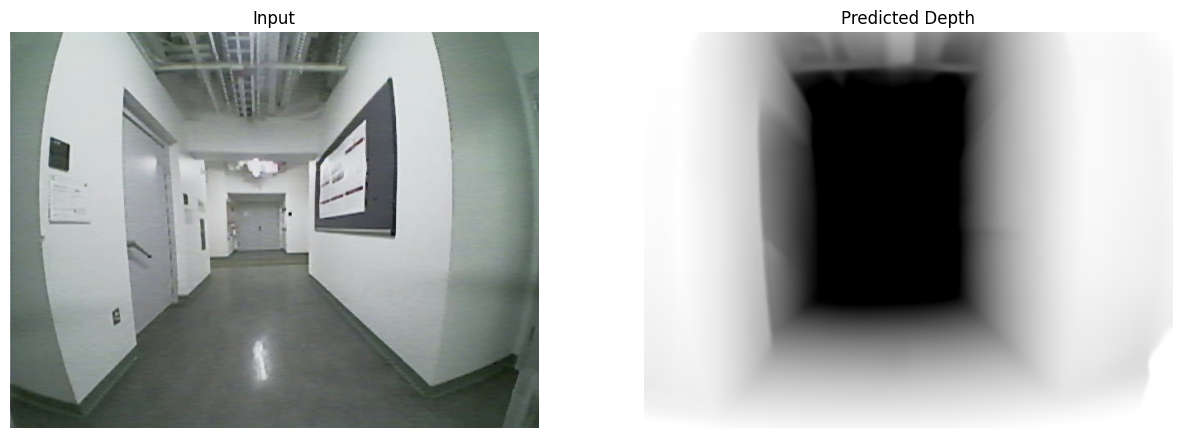

In [29]:
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# ZoeDepth imports
import sys
sys.path.insert(0, "ZoeDepth")
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.utils.misc import get_image_from_url, colorize


# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
conf = get_config("zoedepth", "eval")
model_zoe = build_model(conf)
zoe = model_zoe.to(DEVICE)
zoe.eval()

# Helper function to load image from URL
def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

# Load image from URL
img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w"
img = get_image_from_url(img_url)

img = Image.open("/home/mikea/Documents/Projects/Crazyflie/monocular_reconstruction/MonoNav/data/demo_hallway/crazyflie-rgb-images/crazyflie_frame-000001.rgb.jpg")
# Run ZoeDepth
depth_numpy = zoe.infer_pil(img)

# Colorize depth for visualization
colored_depth = colorize(depth_numpy)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(title)
plt.show()

pcd = make_o3d_pointcloud(np.array(img), depth_numpy, fx, fy, cx, cy)
o3d.visualization.draw_geometries([pcd])
